In [1]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import plot_importance
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)

In [2]:
identifier_name = 'flight_id'
target_name = 'tow'
global_random_state = 123

In [3]:
encoded_challenge_set = pd.read_csv('data/encoded_challenge_set.csv')

display(encoded_challenge_set)

,flight_id,month_day,month,day,actual_offblock_time_hour_minute,actual_offblock_time_hour,actual_offblock_time_minute,adep,country_code_adep,arrival_time_hour_minute,arrival_time_hour,arrival_time_minute,ades,country_code_ades,aircraft_type,wtc,airline,flight_duration,taxiout_time,flown_distance,tow,latitude_count,latitude_mean,latitude_std,latitude_min,latitude_25percentile,latitude_median,latitude_75percentile,latitude_max,longitude_count,longitude_mean,longitude_std,longitude_min,longitude_25percentile,longitude_median,longitude_75percentile,longitude_max,altitude_count,altitude_mean,altitude_std,altitude_min,altitude_25percentile,altitude_median,altitude_75percentile,altitude_max,groundspeed_count,groundspeed_mean,groundspeed_std,groundspeed_min,groundspeed_25percentile,groundspeed_median,groundspeed_75percentile,groundspeed_max,track_count,track_mean,track_std,track_min,track_25percentile,track_median,track_75percentile,track_max,vertical_rate_count,vertical_rate_mean,vertical_rate_std,vertical_rate_min,vertical_rate_25percentile,vertical_rate_median,vertical_rate_75percentile,vertical_rate_max,u_component_of_wind_count,u_component_of_wind_mean,u_component_of_wind_std,u_component_of_wind_min,u_component_of_wind_25percentile,u_component_of_wind_median,u_component_of_wind_75percentile,u_component_of_wind_max,v_component_of_wind_count,v_component_of_wind_mean,v_component_of_wind_std,v_component_of_wind_min,v_component_of_wind_25percentile,v_component_of_wind_median,v_component_of_wind_75percentile,v_component_of_wind_max,temperature_count,temperature_mean,temperature_std,temperature_min,temperature_25percentile,temperature_median,temperature_75percentile,temperature_max,specific_humidity_count,specific_humidity_mean,specific_humidity_std,specific_humidity_min,specific_humidity_25percentile,specific_humidity_median,specific_humidity_75percentile,specific_humidity_max
0,248763780,0,1,1,826,13,46,70,37,904,15,4,82,36,4,1,20,61,18,321,54748.000000,3614,51.837035,0.161396,51.453232,51.774945,51.892997,51.942919,52.028643,3614,-4.817843,2.655620,-8.574295,-7.346304,-4.895513,-2.418875,-0.443802,3614,20991.546763,11779.780447,-25.0,9550.00,26175.0,32000.0,44925.0,3614,317.680733,78.038696,102.0,260.25,362.0,368.0,390.0,3614,266.916090,31.242167,158.552264,270.944437,274.162435,275.911467,294.606984,3614,9.470294,1609.709745,-5696.0,-704.0,0.0,368.0,5568.0,3614,31.190835,11.226974,2.079101,21.859036,33.315629,42.312533,43.086684,3614,28.838399,10.453295,6.718876,18.656661,34.227659,38.804418,39.661651,3614,245.133930,23.513594,214.398682,223.693654,233.527545,268.945607,288.078244,3614,0.001569,0.002304,0.000003,0.000022,0.000114,0.002915,0.008067
1,248760618,0,1,1,595,9,55,220,33,1177,19,37,168,80,18,0,10,570,13,4193,185441.000000,10358,36.416839,6.193836,25.803905,31.443732,35.748230,42.505463,43.390968,10358,-37.864321,32.832625,-80.492389,-66.559062,-60.346413,-4.094342,2.097078,10358,29599.616239,11763.166165,-350.0,33000.00,33000.0,38000.0,60500.0,10358,422.276898,99.069028,109.0,431.00,456.0,484.0,495.0,10358,249.189327,44.338665,0.000000,230.543696,238.620818,283.594836,359.699238,10358,80.330693,691.174222,-1984.0,0.0,0.0,0.0,3328.0,10358,18.727762,10.305791,-2.300409,11.039084,20.462232,25.202863,37.516757,10358,-11.067672,26.301068,-55.784183,-38.585465,2.571138,8.923772,24.558820,10358,231.419524,27.394109,211.161961,213.591163,221.159904,221.850708,298.691536,10358,0.001025,0.003064,0.000002,0.000028,0.000044,0.000085,0.013049
2,248753824,0,1,1,579,9,39,139,88,1148,19,8,171,80,7,0,18,554,15,3770,230396.000000,12932,54.653675,8.598085,41.965164,44.087809,60.114143,61.133171,63.104782,12932,-33.600731,43.183849,-88.239066,-85.001760,-22.770120,7.996781,17.939514,12932,29266.370244,12070.365491,-125.0,24275.00,36000.0,36000.0,47800.0,12932,360.673250,82.928796,89.0,334.00,376.0,406.0,470.0,12932,245.620910,50.973566,1.423205,227.842138,269.252706,278.778859,359.288288,12932,-38.192179,687.891983,-1728.0,0.0,0.0,0.0,3072.0,

In [4]:
features = encoded_challenge_set.drop(columns=[target_name]).copy()
display(features)

target = encoded_challenge_set[[target_name]].copy()
display(target)

,flight_id,month_day,month,day,actual_offblock_time_hour_minute,actual_offblock_time_hour,actual_offblock_time_minute,adep,country_code_adep,arrival_time_hour_minute,arrival_time_hour,arrival_time_minute,ades,country_code_ades,aircraft_type,wtc,airline,flight_duration,taxiout_time,flown_distance,latitude_count,latitude_mean,latitude_std,latitude_min,latitude_25percentile,latitude_median,latitude_75percentile,latitude_max,longitude_count,longitude_mean,longitude_std,longitude_min,longitude_25percentile,longitude_median,longitude_75percentile,longitude_max,altitude_count,altitude_mean,altitude_std,altitude_min,altitude_25percentile,altitude_median,altitude_75percentile,altitude_max,groundspeed_count,groundspeed_mean,groundspeed_std,groundspeed_min,groundspeed_25percentile,groundspeed_median,groundspeed_75percentile,groundspeed_max,track_count,track_mean,track_std,track_min,track_25percentile,track_median,track_75percentile,track_max,vertical_rate_count,vertical_rate_mean,vertical_rate_std,vertical_rate_min,vertical_rate_25percentile,vertical_rate_median,vertical_rate_75percentile,vertical_rate_max,u_component_of_wind_count,u_component_of_wind_mean,u_component_of_wind_std,u_component_of_wind_min,u_component_of_wind_25percentile,u_component_of_wind_median,u_component_of_wind_75percentile,u_component_of_wind_max,v_component_of_wind_count,v_component_of_wind_mean,v_component_of_wind_std,v_component_of_wind_min,v_component_of_wind_25percentile,v_component_of_wind_median,v_component_of_wind_75percentile,v_component_of_wind_max,temperature_count,temperature_mean,temperature_std,temperature_min,temperature_25percentile,temperature_median,temperature_75percentile,temperature_max,specific_humidity_count,specific_humidity_mean,specific_humidity_std,specific_humidity_min,specific_humidity_25percentile,specific_humidity_median,specific_humidity_75percentile,specific_humidity_max
0,248763780,0,1,1,826,13,46,70,37,904,15,4,82,36,4,1,20,61,18,321,3614,51.837035,0.161396,51.453232,51.774945,51.892997,51.942919,52.028643,3614,-4.817843,2.655620,-8.574295,-7.346304,-4.895513,-2.418875,-0.443802,3614,20991.546763,11779.780447,-25.0,9550.00,26175.0,32000.0,44925.0,3614,317.680733,78.038696,102.0,260.25,362.0,368.0,390.0,3614,266.916090,31.242167,158.552264,270.944437,274.162435,275.911467,294.606984,3614,9.470294,1609.709745,-5696.0,-704.0,0.0,368.0,5568.0,3614,31.190835,11.226974,2.079101,21.859036,33.315629,42.312533,43.086684,3614,28.838399,10.453295,6.718876,18.656661,34.227659,38.804418,39.661651,3614,245.133930,23.513594,214.398682,223.693654,233.527545,268.945607,288.078244,3614,0.001569,0.002304,0.000003,0.000022,0.000114,0.002915,0.008067
1,248760618,0,1,1,595,9,55,220,33,1177,19,37,168,80,18,0,10,570,13,4193,10358,36.416839,6.193836,25.803905,31.443732,35.748230,42.505463,43.390968,10358,-37.864321,32.832625,-80.492389,-66.559062,-60.346413,-4.094342,2.097078,10358,29599.616239,11763.166165,-350.0,33000.00,33000.0,38000.0,60500.0,10358,422.276898,99.069028,109.0,431.00,456.0,484.0,495.0,10358,249.189327,44.338665,0.000000,230.543696,238.620818,283.594836,359.699238,10358,80.330693,691.174222,-1984.0,0.0,0.0,0.0,3328.0,10358,18.727762,10.305791,-2.300409,11.039084,20.462232,25.202863,37.516757,10358,-11.067672,26.301068,-55.784183,-38.585465,2.571138,8.923772,24.558820,10358,231.419524,27.394109,211.161961,213.591163,221.159904,221.850708,298.691536,10358,0.001025,0.003064,0.000002,0.000028,0.000044,0.000085,0.013049
2,248753824,0,1,1,579,9,39,139,88,1148,19,8,171,80,7,0,18,554,15,3770,12932,54.653675,8.598085,41.965164,44.087809,60.114143,61.133171,63.104782,12932,-33.600731,43.183849,-88.239066,-85.001760,-22.770120,7.996781,17.939514,12932,29266.370244,12070.365491,-125.0,24275.00,36000.0,36000.0,47800.0,12932,360.673250,82.928796,89.0,334.00,376.0,406.0,470.0,12932,245.620910,50.973566,1.423205,227.842138,269.252706,278.778859,359.288288,12932,-38.192179,687.891983,-1728.0,0.0,0.0,0.0,3072.0,12932,28.021542,26.887714,-11.437739,-1.27958

,tow
0,54748.000000
1,185441.000000
2,230396.000000
3,157615.000000
4,70318.447226
...,...
369008,163438.000000
369009,78707.000000
369010,62942.750000
369011,72611.161024


In [5]:
# Function to score model using Root Mean Square Error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
# Create a scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Make cross validation strategy
cv_strategy = KFold(n_splits=2, shuffle=True, random_state=global_random_state)

In [6]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 1.0],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    eval_metric='rmse',
    random_state=global_random_state
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', # Use RMSE (negative because scikit-learn maximizes scores)
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(features, target)

best_params = grid_search.best_params_
print("Best parameters:", best_params)
print("Best RMSE:", -grid_search.best_score_) # Negate the score to get RMSE

Fitting 2 folds for each of 45 candidates, totalling 90 fits
Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.3, 'subsample': 1.0}
Best RMSE: 3422.926493927152


<Figure size 1000x800 with 0 Axes>

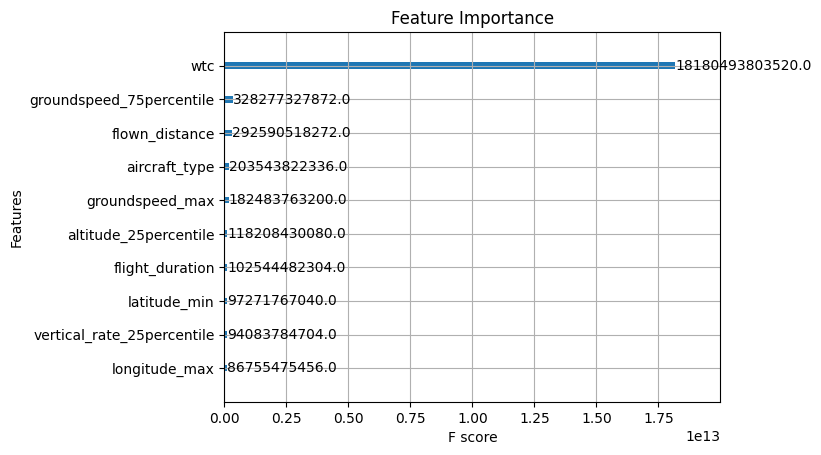

In [7]:
best_model = grid_search.best_estimator_

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_model, importance_type='gain', max_num_features=10)
plt.title('Feature Importance')
plt.show()

In [8]:
booster = best_model.get_booster()

# Create a DataFrame with all feature names
all_features = pd.DataFrame(features.columns, columns=['Feature'])

# Get the importance of the features
importance_dict = booster.get_score(importance_type='gain')
importance_df = pd.DataFrame(importance_dict.items(), columns=['Feature', 'Importance'])

# Merge with all features to include those with zero importance
importance_full_df = all_features.merge(importance_df, on='Feature', how='left').fillna(0)

# Sort the DataFrame in ascending order
importance_full_df_sorted = importance_full_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

display(importance_full_df_sorted)

,Feature,Importance
0,wtc,1.818049e+13
1,groundspeed_75percentile,3.282773e+11
2,flown_distance,2.925905e+11
3,aircraft_type,2.035438e+11
4,groundspeed_max,1.824838e+11
...,...,...
95,groundspeed_count,0.000000e+00
96,track_count,0.000000e+00
97,vertical_rate_count,0.000000e+00
98,v_component_of_wind_count,0.000000e+00


In [9]:
print(list(importance_full_df_sorted["Importance"].values))

[18180493803520.0, 328277327872.0, 292590518272.0, 203543822336.0, 182483763200.0, 118208430080.0, 102544482304.0, 97271767040.0, 94083784704.0, 86755475456.0, 64399335424.0, 45367681024.0, 36195123200.0, 32325771264.0, 28009654272.0, 26612897792.0, 19836942336.0, 19465457664.0, 16113215488.0, 14156463104.0, 12517895168.0, 10996370432.0, 8701611008.0, 8560721408.0, 5326611456.0, 4858687488.0, 3824307712.0, 3811368448.0, 3357426176.0, 2741994752.0, 2649946368.0, 2636589568.0, 2330958080.0, 2295575040.0, 2165517824.0, 1927104896.0, 1774675840.0, 1460965120.0, 1397504128.0, 1285978240.0, 1224667264.0, 1076176896.0, 1066895232.0, 1059200576.0, 978850112.0, 901520832.0, 892581568.0, 855373120.0, 845192704.0, 834080832.0, 829540544.0, 814136256.0, 770320384.0, 727827520.0, 706749760.0, 700280768.0, 698212352.0, 662707456.0, 646879296.0, 598044864.0, 579341824.0, 567689536.0, 541624704.0, 535749888.0, 531809536.0, 519854144.0, 512497792.0, 495093824.0, 487292448.0, 481465440.0, 476567072.0, 4

In [11]:
print(str(list(importance_full_df_sorted["Feature"].values)).replace(",", ",\n"))

['wtc',
 'groundspeed_75percentile',
 'flown_distance',
 'aircraft_type',
 'groundspeed_max',
 'altitude_25percentile',
 'flight_duration',
 'latitude_min',
 'vertical_rate_25percentile',
 'longitude_max',
 'airline',
 'altitude_median',
 'vertical_rate_std',
 'altitude_75percentile',
 'longitude_std',
 'ades',
 'latitude_max',
 'adep',
 'vertical_rate_max',
 'longitude_mean',
 'latitude_std',
 'groundspeed_min',
 'vertical_rate_median',
 'latitude_median',
 'country_code_adep',
 'longitude_min',
 'latitude_mean',
 'country_code_ades',
 'specific_humidity_median',
 'vertical_rate_75percentile',
 'taxiout_time',
 'latitude_25percentile',
 'track_25percentile',
 'month_day',
 'altitude_mean',
 'latitude_75percentile',
 'longitude_median',
 'longitude_75percentile',
 'flight_id',
 'vertical_rate_mean',
 'longitude_25percentile',
 'arrival_time_hour_minute',
 'track_mean',
 'temperature_max',
 'latitude_count',
 'groundspeed_25percentile',
 'track_75percentile',
 'altitude_std',
 'actual_o